In [2]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from scipy import integrate
import os
import seaborn as sns

sns.set_style('whitegrid')

In [3]:
from scipy.interpolate import interp1d

# Load the data
data = np.loadtxt("kaon_decay_efficiency_data.txt", skiprows=2)

# Extract columns
m_n = data[:, 0]
mu_decay = data[:, 1]
e_decay = data[:, 2]

# Calculate the minimum between mu and e decay for each entry
min_decay = np.minimum(mu_decay, e_decay)

# Create interpolation function
extended_m_n = np.arange(150, 2001, 25)
extended_mu = np.interp(extended_m_n, m_n, mu_decay)
extended_e = np.interp(extended_m_n, m_n, e_decay)
extended_min = np.minimum(extended_mu, extended_e)

# Create interpolation function
min_efficiency_interp = interp1d(extended_m_n, extended_min, kind='linear', fill_value='extrapolate')

def get_min_efficiency(m_n_value):
    return min_efficiency_interp(m_n_value)

background = {'nu':0.563, 'antinu':0.015}

# Pair Production CDF Sampling
## Electron - Positron Energy Sampling from Branching Ratio 

### For each events
Branching ratio from equation A4 in Matheus' & Carlos' https://arxiv.org/abs/2109.03831

<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1233005/622892519.py:53: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'E+ Distribution\nm={params["m"]}, $\mu$={params["mu"]}, $E_T$={params["etotal"]}')
/tmp/ipykernel_1233005/622892519.py:64: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'E- Distribution\nm={params["m"]}, $\mu$={params["mu"]}, $E_T$={params["etotal"]}')


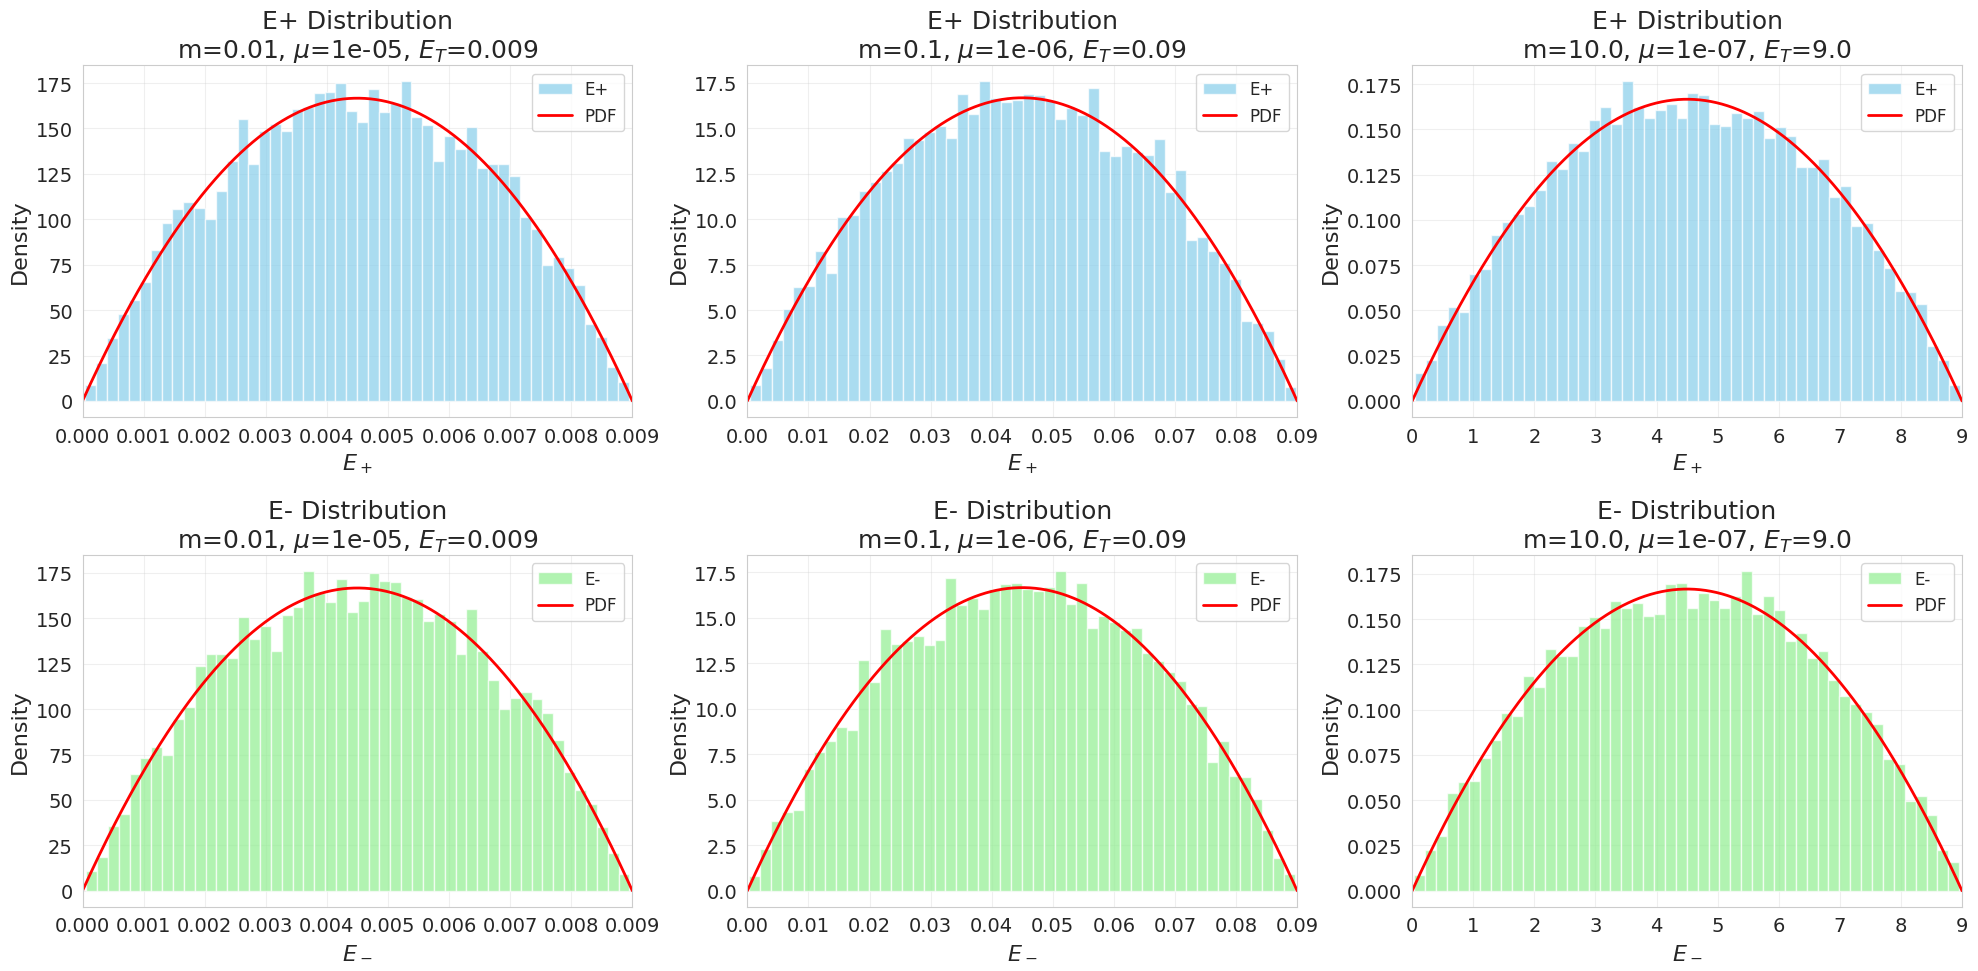

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cdf_sampling(pdf_func, num_samples, m, mu, etotal):
    # Define Energy Sampling Range
    x_range = (0, etotal)
    # Step 1: Create a fine grid for x values
    x_values = np.linspace(x_range[0], x_range[1], 1000)
    # Step 2: Calculate PDF values
    pdf_values = pdf_func(x_values, m, mu, etotal)
    # Step 3: Normalize the PDF
    pdf_normalized = pdf_values / np.trapz(pdf_values, x_values)
    # Step 4: Calculate the CDF using cumulative sum
    cdf_values = np.cumsum(pdf_normalized) * (x_values[1] - x_values[0])
    cdf_values /= cdf_values[-1]  # Ensure the CDF ends at 1
    # Step 5: Generate uniform random numbers
    u = np.random.uniform(0, 1, num_samples)
    # Step 6: Inverse transform sampling
    samples = np.interp(u, cdf_values, x_values)
    return samples, x_range

# Branching ratio of ep = E+ and em = E-, etotal = ep + em
def Gamma_ee(ep, m, mu, etotal):
    alpha = 1/137  # Fine-structure constant
    return alpha * mu**2 * m * etotal - 4 * (etotal - ep) * ep / (8 * np.pi**2 * etotal - m / 2)

# Example usage
num_samples = 10000  # Increased for better visualization

# Define different sets of parameters
param_sets = [
    {'m': 1e-2, 'mu': 1e-5, 'etotal': 0.9e-2},
    {'m': 1e-1, 'mu': 1e-6, 'etotal': 0.9e-1},
    {'m': 1e1, 'mu': 1e-7, 'etotal': 0.9e1}
]

plt.figure(figsize=(20, 10))

for i, params in enumerate(param_sets, 1):
    # Generate samples
    samples_eplus, x_range = cdf_sampling(Gamma_ee, num_samples, params['m'], params['mu'], params['etotal'])
    
    # Calculate E- samples
    samples_eminus = params['etotal'] - samples_eplus
    
    # Visualize results for E+
    plt.subplot(2, 3, i)
    plt.hist(samples_eplus, bins=50, density=True, alpha=0.7, color='skyblue', label='E+')
    x = np.linspace(x_range[0], x_range[1], 1000)
    pdf_values = Gamma_ee(x, params['m'], params['mu'], params['etotal'])
    normalization = np.trapz(pdf_values, x)
    plt.plot(x, pdf_values / normalization, 'r-', lw=2, label='PDF')
    plt.title(f'E+ Distribution\nm={params["m"]}, $\mu$={params["mu"]}, $E_T$={params["etotal"]}')
    plt.xlabel('$E_+$')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.xlim(x_range)
    plt.legend()

    # Visualize results for E-
    plt.subplot(2, 3, i+3)
    plt.hist(samples_eminus, bins=50, density=True, alpha=0.7, color='lightgreen', label='E-')
    plt.plot(x, pdf_values / normalization, 'r-', lw=2, label='PDF')
    plt.title(f'E- Distribution\nm={params["m"]}, $\mu$={params["mu"]}, $E_T$={params["etotal"]}')
    plt.xlabel('$E_-$')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.xlim(x_range)
    plt.legend()

plt.tight_layout()
plt.show()

### Resample from MC Results

Picking the experiment and samples

In [4]:
# Choose your set of events
# ND280+ Projected POT
POT = 2.6098758621e22
# ND280 Cumulative POT
POTOGNeu = 1.234e21
POTOGAnti = 6.29e20
me = 0.511e-3 # Electron mass in GeV/c^2


def normalize_vectors(vectors):
    vectors_array = np.array(vectors)
    magnitudes = np.linalg.norm(vectors_array, axis=1, keepdims=True)
    magnitudes = np.where(magnitudes == 0, 1, magnitudes)
    normalized_vectors = vectors_array / magnitudes
    return normalized_vectors

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

i = 65; exp = 'TPC2'
m = m_sample[i]
mu = mu_sample[i]

path=f"{exp}_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m,mu)
            
if os.path.isfile('./output/'+path):
    data = ak.from_parquet("output/"+path)
    
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    weights = np.array(np.squeeze(data['event_weight'] * fid_flag * (POT)))
    
    # nu out
    nuout_flag = data["secondary_types"]==5910
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = ak.mask(nuout_momenta, ak.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~ak.is_none(nuout_momenta,axis=1)])

    # N
    N_flag = data["primary_type"]==5914
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    flag = data["secondary_types"]==22
    gamma_momenta = data["secondary_momenta"][flag]
    # mask out entries that are not gamma
    gamma_momenta = ak.mask(gamma_momenta, ak.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~ak.is_none(gamma_momenta,axis=1)])
    
    gamma_ETotal = np.array(gamma_momenta[:,0])
    gamma_direction = normalize_vectors(gamma_momenta[:,1:])
    
else:
    print('File '+path+' not found.')
    

### CUT 1: HNL incident angle

In [9]:
precut_weights = weights

# # Invariant mass cut Mcon < 0.7 GeV
# weights = np.vectorize(lambda x:x<=0.7)(gamma_ETotal)*weights
# print(f'Energy recon < 0.7 survival rate: {np.sum(weights)/np.sum(precut_weights)*100:f}')
# N incident angle cos(theta) > 0.99 for e+e- channel
weights = np.vectorize(lambda x:x>0.999)(N_momenta[:,3]/np.linalg.norm(N_momenta[:,1:],axis=1))*weights
# print(f'N incident angle | energy recon survival rate: {np.sum(weights)/np.sum(precut_weights)*100:f}')


print(f'The number of events before the cut: {np.sum(precut_weights)}')
print(f'The number of events after the cut: {np.sum(weights)}')
print(f'Overall survival rate: {np.sum(weights)/np.sum(precut_weights)*100:f} %')

The number of events before the cut: 2951988.548483806
The number of events after the cut: 2951988.548483806
Overall survival rate: 100.000000 %


### Weight Upscale

In [6]:
upscale = 1/np.min(weights[np.nonzero(weights)])
original_weights = weights
weights = weights * upscale

print(f'Weights sum before upscale {np.sum(original_weights):3f} ')
print(f'Weights upscaled by {upscale:3f}')

Weights sum before upscale 117276.092794 
Weights upscaled by 25.171273


In [10]:
original_weights = weights
weightscale = 1e5/np.sum(weights)
weights *= weightscale

print(f'Weights sum before upscale {np.sum(original_weights):3f} ')
print(f'Weights upscaled by {upscale:3f}')

Weights sum before upscale 100000.000000 
Weights upscaled by 25.171273


Sample $N=\text{weight}\times\text{POT}$ events for each photon events to get a spectra of electrons

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def cdf_sampling(pdf_func, num_samples, m, mu, etotal):
    # Define Energy Sampling Range
    x_range = (0, etotal)
    # Step 1: Create a fine grid for x values
    x_values = np.linspace(x_range[0], x_range[1], 1000)
    # Step 2: Calculate PDF values
    pdf_values = pdf_func(x_values, m, mu, etotal)
    # Step 3: Normalize the PDF
    pdf_normalized = pdf_values / np.trapz(pdf_values, x_values)
    # Step 4: Calculate the CDF using cumulative sum
    cdf_values = np.cumsum(pdf_normalized) * (x_values[1] - x_values[0])
    cdf_values /= cdf_values[-1]  # Ensure the CDF ends at 1
    # Step 5: Generate uniform random numbers
    u = np.random.uniform(0, 1, num_samples)
    # Step 6: Inverse transform sampling
    samples = np.interp(u, cdf_values, x_values)
    return samples

# Branching ratio of ep = E+ and em = E-, etotal = ep + em
def Gamma_ee(ep, m, mu, etotal):
    alpha = 1/137  # Fine-structure constant
    return alpha * mu**2 * m * etotal - 4 * (etotal - ep) * ep / (8 * np.pi**2 * etotal - m / 2)

def costheta_subtended(numtm, Nmtm, Eplus, Eminus):
    pNpnu = numtm[0]*Nmtm[0] - np.dot(numtm[1:],Nmtm[1:])
    pplus = np.sqrt(Eplus**2 - me**2)
    pminus = np.sqrt(Eminus**2 - me**2)
    costheta = ( Eplus*Eminus + pNpnu - m**2/2)/(pplus*pminus)
    return costheta

def apply_gaussian_smearing(values, relative_sigma):
    absolute_sigma = values * relative_sigma
    smeared_values = np.random.normal(values, absolute_sigma)
    return np.maximum(smeared_values, 0)  # Ensure non-negative energies

def apply_costheta_smearing(costheta, sigma):
    smeared_costheta = np.random.normal(costheta, sigma)
    return np.clip(smeared_costheta, -1, 1) # Clip to cosθ range

samples_per_etotal = 1  # Number of samples per event
relative_sigma_plus = 0.078  # 0.78% relative sigma
relative_sigma_minus = 0.078  # 0.78% relative sigma
costheta_sigma = 0.01

# Photon energy distribution and event weights
etotal_values = gamma_ETotal
etotal_weights = weights  # Normalised to POT
numtms = nuout_momenta
Nmtms = N_momenta
directions = gamma_direction

# Generate samples for each etotal value
all_samples_eplus_original = []
all_samples_eminus_original = []
all_samples_eplus = []
all_samples_eminus = []
all_samples_angle_original = []
all_samples_angle = []
all_gamma = []
all_eplus_mtm = []
all_eminus_mtm = []

for etotal, weight, numtm, Nmtm, direction in tqdm(zip(etotal_values, etotal_weights, numtms, Nmtms, directions), total=len(etotal_values), desc="Processing events"):
    num_samples = int(samples_per_etotal * weight)
    samples_eplus = cdf_sampling(Gamma_ee, num_samples, m, mu, etotal)
    samples_eminus = etotal - samples_eplus
    
    # Store original values
    all_samples_eplus_original.extend(samples_eplus)
    all_samples_eminus_original.extend(samples_eminus)
    
    # Apply Gaussian smearing to E+ and E-
    smeared_eplus = apply_gaussian_smearing(samples_eplus, relative_sigma_plus)
    smeared_eminus = apply_gaussian_smearing(samples_eminus, relative_sigma_minus)
    
    # Calculate costheta before smearing
    samples_angle_original = costheta_subtended(numtm, Nmtm, smeared_eplus, smeared_eminus)
    all_samples_angle_original.extend(samples_angle_original)
    
    # Apply Gaussian smearing to costheta
    samples_angle_smeared = apply_costheta_smearing(samples_angle_original, costheta_sigma)
    
    eplus_mtm = np.sqrt(smeared_eplus**2 - me**2) * np.array(direction).reshape(-1, 1)
    eminus_mtm = np.sqrt(smeared_eminus**2 - me**2) * np.array(direction).reshape(-1, 1)
    
    all_samples_eplus.extend(smeared_eplus)
    all_samples_eminus.extend(smeared_eminus)
    all_gamma.extend(smeared_eplus + smeared_eminus)
    all_samples_angle.extend(samples_angle_smeared)
    all_eplus_mtm.extend(eplus_mtm)
    all_eminus_mtm.extend(eminus_mtm)
    
    
# Convert to numpy arrays for easier manipulation
all_samples_eplus_original = np.array(all_samples_eplus_original)
all_samples_eminus_original = np.array(all_samples_eminus_original)
all_samples_eplus = np.array(all_samples_eplus)
all_samples_eminus = np.array(all_samples_eminus)
all_samples_angle_original = np.array(all_samples_angle_original)
all_samples_angle = np.array(all_samples_angle)
all_samples_diff = all_samples_eplus - all_samples_eminus


Processing events: 100%|██████████| 100000/100000 [00:35<00:00, 2847.90it/s]


Total samples: 98766
E+ mean (before): 1.44e+00 GeV
E+ mean (after): 1.44e+00 GeV
E- mean (before): 1.44e+00 GeV
E- mean (after): 1.44e+00 GeV
E+ - E- mean: 3.42e-03 GeV
Weighted Etotal mean: 2.85e+05 GeV
E+ range: 1.28e-03 to 1.08e+01 GeV
E- range: 7.25e-04 to 1.13e+01 GeV
E+ - E- range: -1.09e+01 to 1.04e+01 GeV
Cosθ range: 9.58e-01 to 1.00e+00
Cosθ mean: 9.96e-01
Cosθ median: 1.00e+00
Cosθ standard deviation: 5.84e-03
Number of values outside [-1, 1]: 0

Smearing Statistics:
E+ relative sigma: 7.80%
E- relative sigma: 7.80%
E+ mean absolute sigma: 1.12e-01 GeV
E- mean absolute sigma: 1.12e-01 GeV
E+ mean smearing effect: 4.38e-04 GeV
E- mean smearing effect: -2.68e-04 GeV
Total E mean smearing effect: 1.69e-04 GeV


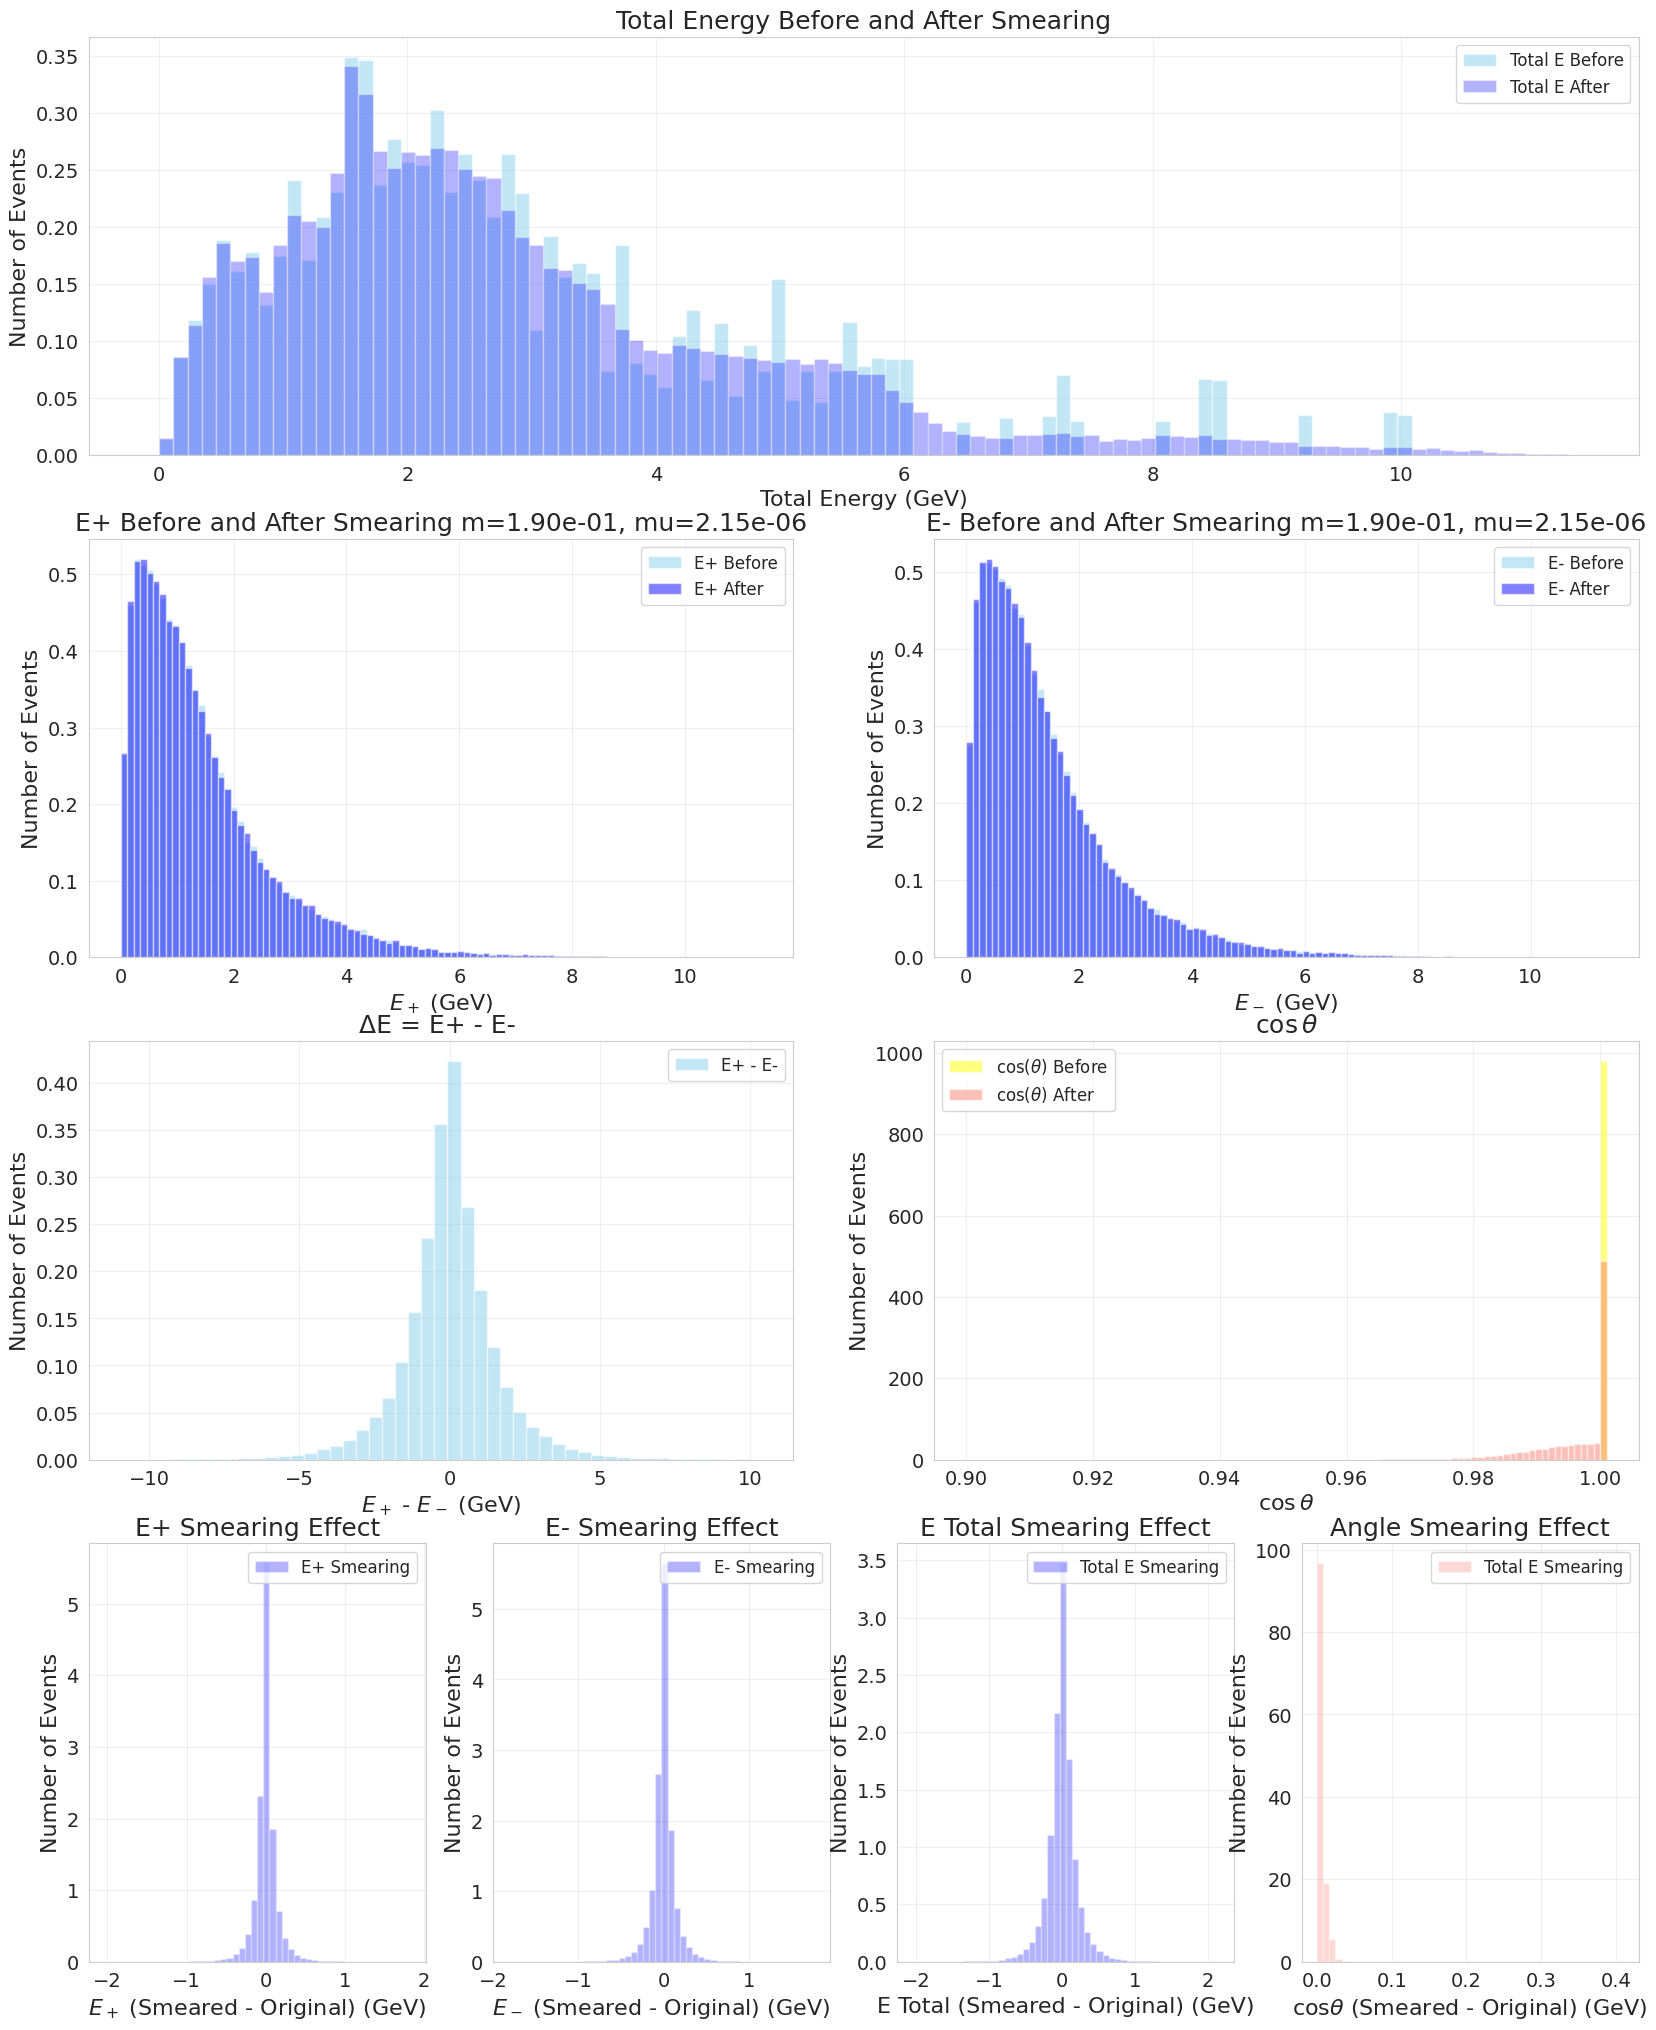

In [12]:
e_min = min(np.min(all_samples_eplus), np.min(all_samples_eminus))
e_max = max(np.max(all_samples_eplus), np.max(all_samples_eminus))
diff_min, diff_max = np.min(all_samples_diff), np.max(all_samples_diff)
diff_min_t, diff_max_t = np.min(etotal_values), np.max(etotal_values)
angle_min, angle_max = np.min(all_samples_angle), np.max(all_samples_angle)

bins = np.linspace(e_min, e_max, 100)
diff_bins = np.linspace(diff_min, diff_max, 50)
diff_bins_t = np.linspace(diff_min_t, diff_max_t, 50)
bins_angle = np.linspace(0.9, 1.001, 100)  # Use full range of cosine

plt.figure(figsize=(20, 25))


# Total energy before and after smearing
plt.subplot(4, 1, 1)
total_energy_before = all_samples_eplus_original + all_samples_eminus_original
total_energy_after = all_samples_eplus + all_samples_eminus
plt.hist(total_energy_before, bins=bins, density=True, alpha=0.5, color='skyblue', label='Total E Before')
plt.hist(total_energy_after, bins=bins, density=True, alpha=0.3, color='blue', label='Total E After')
plt.title('Total Energy Before and After Smearing')
plt.xlabel('Total Energy (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# E+ distribution before and after smearing
plt.subplot(4, 2, 3)
plt.hist(all_samples_eplus_original, bins=bins, density=True, alpha=0.5, color='skyblue', label='E+ Before')
plt.hist(all_samples_eplus, bins=bins, density=True, alpha=0.5, color='blue', label='E+ After')
plt.title(rf'E+ Before and After Smearing m={m:.2e}, mu={mu:.2e}')
plt.xlabel(r'$E_+$ (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# E- distribution before and after smearing
plt.subplot(4, 2, 4)
plt.hist(all_samples_eminus_original, bins=bins, density=True, alpha=0.5, color='skyblue', label='E- Before')
plt.hist(all_samples_eminus, bins=bins, density=True, alpha=0.5, color='blue', label='E- After')
plt.title(rf'E- Before and After Smearing m={m:.2e}, mu={mu:.2e}')
plt.xlabel(r'$E_-$ (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# E+ - E- distribution
plt.subplot(4, 2, 5)
plt.hist(all_samples_diff, bins=diff_bins, density=True, alpha=0.5, color='skyblue', label='E+ - E-')
plt.title(rf'ΔE = E+ - E- ')
plt.xlabel(r'$E_+$ - $E_-$ (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# Cosθ distribution
plt.subplot(4, 2, 6)
plt.hist(all_samples_angle_original, bins=bins_angle, density=True, alpha=0.5, color='yellow', label=r'cos($\theta$) Before')
plt.hist(all_samples_angle, bins=bins_angle, density=True, alpha=0.5, color='salmon', label=r'cos($\theta$) After')
plt.title(rf'$\cos\theta$ ')
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Number of Events')
# plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()

# E+ smearing effect
plt.subplot(4, 4, 13)
plt.hist(all_samples_eplus - all_samples_eplus_original, bins=50, density=True, alpha=0.3, color='blue', label='E+ Smearing')
plt.title(r'E+ Smearing Effect')
plt.xlabel(r'$E_+$ (Smeared - Original) (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# E- smearing effect
plt.subplot(4, 4, 14)
plt.hist(all_samples_eminus - all_samples_eminus_original, bins=50, density=True, alpha=0.3, color='blue', label='E- Smearing')
plt.title(r'E- Smearing Effect')
plt.xlabel(r'$E_-$ (Smeared - Original) (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# ET smearing effect
plt.subplot(4, 4, 15)
plt.hist(total_energy_after - total_energy_before, bins=50, density=True, alpha=0.3, color='blue', label='Total E Smearing')
plt.title(r'E Total Smearing Effect')
plt.xlabel(r'E Total (Smeared - Original) (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()

# Angle smearing effect
plt.subplot(4, 4, 16)
plt.hist(all_samples_angle_original - all_samples_angle, bins=50, density=True, alpha=0.3, color='salmon', label='Total E Smearing')
plt.title(r'Angle Smearing Effect')
plt.xlabel(r'cos$\theta$ (Smeared - Original) (GeV)')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.legend()


# # E- smearing effect
# plt.subplot(5, 2, 8)
# plt.hist(all_samples_eminus - all_samples_eminus_original, bins=50, density=True, alpha=0.7, color='green', label='E- Smearing')
# plt.title(r'E- Smearing Effect')
# plt.xlabel(r'$E_-$ (Smeared - Original) (GeV)')
# plt.ylabel('Number of Events')
# plt.grid(True, alpha=0.3)
# plt.legend()


# # Total energy smearing effect
# plt.subplot(5, 2, 10)
# plt.hist(total_energy_after - total_energy_before, bins=50, density=True, alpha=0.7, color='purple', label='Total E Smearing')
# plt.title('Total Energy Smearing Effect')
# plt.xlabel('Total Energy (Smeared - Original) (GeV)')
# plt.ylabel('Number of Events')
# plt.grid(True, alpha=0.3)
# plt.legend()

# plt.tight_layout()
# plt.show()

# Display some statistics
print(f"Total samples: {len(all_samples_eplus)}")
print(f"E+ mean (before): {np.mean(all_samples_eplus_original):.2e} GeV")
print(f"E+ mean (after): {np.mean(all_samples_eplus):.2e} GeV")
print(f"E- mean (before): {np.mean(all_samples_eminus_original):.2e} GeV")
print(f"E- mean (after): {np.mean(all_samples_eminus):.2e} GeV")
print(f"E+ - E- mean: {np.mean(all_samples_diff):.2e} GeV")
print(f"Weighted Etotal mean: {np.sum(etotal_values * etotal_weights):.2e} GeV")
print(f"E+ range: {np.min(all_samples_eplus):.2e} to {np.max(all_samples_eplus):.2e} GeV")
print(f"E- range: {np.min(all_samples_eminus):.2e} to {np.max(all_samples_eminus):.2e} GeV")
print(f"E+ - E- range: {np.min(all_samples_diff):.2e} to {np.max(all_samples_diff):.2e} GeV")

# Display angle statistics
print(f"Cosθ range: {np.min(all_samples_angle):.2e} to {np.max(all_samples_angle):.2e}")
print(f"Cosθ mean: {np.mean(all_samples_angle):.2e}")
print(f"Cosθ median: {np.median(all_samples_angle):.2e}")
print(f"Cosθ standard deviation: {np.std(all_samples_angle):.2e}")
print(f"Number of values outside [-1, 1]: {np.sum(np.abs(all_samples_angle) > 1)}")

# Smearing statistics
print("\nSmearing Statistics:")
print(f"E+ relative sigma: {relative_sigma_plus:.2%}")
print(f"E- relative sigma: {relative_sigma_minus:.2%}")
print(f"E+ mean absolute sigma: {np.mean(all_samples_eplus_original * relative_sigma_plus):.2e} GeV")
print(f"E- mean absolute sigma: {np.mean(all_samples_eminus_original * relative_sigma_minus):.2e} GeV")
print(f"E+ mean smearing effect: {np.mean(all_samples_eplus - all_samples_eplus_original):.2e} GeV")
print(f"E- mean smearing effect: {np.mean(all_samples_eminus - all_samples_eminus_original):.2e} GeV")
print(f"Total E mean smearing effect: {np.mean(total_energy_after - total_energy_before):.2e} GeV")

### CUT 2: e+e- pair angle

In [140]:
signal_strength

95.20617366559053

In [13]:
# Skipping M recon

# Angle subtended 
signal_strength = np.sum(np.vectorize(lambda x:x>np.cos(np.pi/2))(all_samples_angle))
print(f"Number of Samples: {len(all_samples_angle)/upscale:.1f}")
print(f"Samples survived: {signal_strength/upscale:.1f}")
print(f"Pair Production Angle Selection Efficiency: {signal_strength/len(all_samples_angle)*100:.1f} %")
signal_strength = get_min_efficiency(m*1000) * signal_strength / upscale # min_efficiency is in MeV
bkg = background['nu']

Number of Samples: 3923.8
Samples survived: 3923.8
Pair Production Angle Selection Efficiency: 100.0 %


In [14]:
from scipy import stats

def func(s, b):
    # Calculate the test statistic
    test_statistic = np.sqrt(2 * ((s + b) * np.log(1 + s/b) - s))
    
    # Calculate the rejection power
    rejection_power = 1 - stats.norm.cdf(-test_statistic)
    
    return rejection_power

power = func(signal_strength, bkg)
print(f'Signal: {signal_strength:1.1f}, Background: {bkg:.2f}, Power: {power.hex()}')

Signal: 305.9, Background: 0.56, Power: 0x1.0000000000000p+0


: 

# OPTIMISED PIPELINE
HNL incident cut
CDF sampling and smearing
Incident cut

In [ ]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from scipy import integrate
import os
import seaborn as sns
from scipy.interpolate import interp1d

# Load the data
data = np.loadtxt("kaon_decay_efficiency_data.txt", skiprows=2)

# Extract columns
m_n = data[:, 0]
mu_decay = data[:, 1]
e_decay = data[:, 2]

# Calculate the minimum between mu and e decay for each entry
min_decay = np.minimum(mu_decay, e_decay)

# Create interpolation function
extended_m_n = np.arange(150, 2001, 25)
extended_mu = np.interp(extended_m_n, m_n, mu_decay)
extended_e = np.interp(extended_m_n, m_n, e_decay)
extended_min = np.minimum(extended_mu, extended_e)

# Create interpolation function
min_efficiency_interp = interp1d(extended_m_n, extended_min, kind='linear', fill_value='extrapolate')

def get_min_efficiency(m_n_value):
    return min_efficiency_interp(m_n_value)

background = {'nu':0.563, 'antinu':0.015}

# Choose your set of events
# ND280+ Projected POT
POT = 2.6098758621e22
# ND280 Cumulative POT
POTOGNeu = 1.234e21
POTOGAnti = 6.29e20
me = 0.511e-3 # Electron mass in GeV/c^2


def normalize_vectors(vectors):
    vectors_array = np.array(vectors)
    magnitudes = np.linalg.norm(vectors_array, axis=1, keepdims=True)
    magnitudes = np.where(magnitudes == 0, 1, magnitudes)
    normalized_vectors = vectors_array / magnitudes
    return normalized_vectors

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

i = 65; exp = 'TPC2'
m = m_sample[i]
mu = mu_sample[i]

path=f"{exp}_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m,mu)
            
if os.path.isfile('./output/'+path):
    data = ak.from_parquet("output/"+path)
    
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    weights = np.array(np.squeeze(data['event_weight'] * fid_flag * (POT)))
    
    # nu out
    nuout_flag = data["secondary_types"]==5910
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = ak.mask(nuout_momenta, ak.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~ak.is_none(nuout_momenta,axis=1)])

    # N
    N_flag = data["primary_type"]==5914
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    flag = data["secondary_types"]==22
    gamma_momenta = data["secondary_momenta"][flag]
    # mask out entries that are not gamma
    gamma_momenta = ak.mask(gamma_momenta, ak.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~ak.is_none(gamma_momenta,axis=1)])
    
    gamma_ETotal = np.array(gamma_momenta[:,0])
    gamma_direction = normalize_vectors(gamma_momenta[:,1:])
    
else:
    print('File '+path+' not found.')
    